In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

In [195]:
# font_path = "C:/Windows/Fonts/gulim.ttc"
# font = fm.FontProperties(fname=font_path).get_name()
# matplotlib.rc('font', family=font)              # 설정에 해당하는 rc params 변경

In [196]:
# WSL2 font setting
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False) # 마이너스 기호 깨짐 방지

In [197]:
df = pd.read_csv('../data/training/TL_csv/tn_lodge_consume_his_숙박소비내역_E.csv')
df_travel = pd.read_csv('../data/training/TL_csv/tn_travel_여행_E.csv')         # 필요 컬럼 채우기 위해

df['PAYMENT_DT'] = pd.to_datetime(df['PAYMENT_DT'], errors='coerce')
df_travel['TRAVEL_START_YMD'] = pd.to_datetime(df_travel['TRAVEL_START_YMD'], errors='coerce')

df_merged = pd.merge(
    df,
    df_travel[['TRAVEL_ID','TRAVEL_START_YMD']],
    on='TRAVEL_ID',
    how='left'
)

In [198]:
# PAYMENT_DT의 NaN 값을 TRAVEL_START_YMD 값으로 채우기
df_merged['PAYMENT_DT'] = df_merged['PAYMENT_DT'].fillna(df_merged['TRAVEL_START_YMD'])

# PAYMENT_DT 변환
try:
    df_merged['PAYMENT_DT'] = pd.to_datetime(df_merged['PAYMENT_DT'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
except Exception as e:
    print(f"지정된 포맷으로 변환 실패: {e}")
    print("'mixed' 포맷으로 다시 시도합니다.")
    df_merged['PAYMENT_DT'] = pd.to_datetime(df_merged['PAYMENT_DT'], format='mixed', errors='coerce')

In [199]:
# 불필요한 컬럼 삭제 (전부 NaN이거나, 병합 후 중복되는 컬럼)
df_lodge_clean = df_merged.drop(columns=['CHK_IN_DT_MIN', 'CHK_OUT_DT_MIN', 'TRAVEL_START_YMD', 'BRNO', 'ROAD_NM_CD', 'LOTNO_CD', 'PAYMENT_ETC'])

# 결측치
na_columns = ['ROAD_NM_ADDR', 'LOTNO_ADDR', 'STORE_NM']
df_lodge_clean[na_columns] = df_lodge_clean[na_columns].fillna('정보없음')

In [200]:
# RSVT_YN, LODGING_TYPE_CD, PAYMENT_MTHD_SE 인코딩
le = LabelEncoder()
df_lodge_clean['RSVT_YN'] = le.fit_transform(y=df_lodge_clean['RSVT_YN'])
df_lodge_clean['LODGING_TYPE_CD'] = le.fit_transform(y=df_lodge_clean['LODGING_TYPE_CD'])
df_lodge_clean['PAYMENT_MTHD_SE'] = le.fit_transform(y=df_lodge_clean['PAYMENT_MTHD_SE'])

Text(0, 0.5, '빈도')

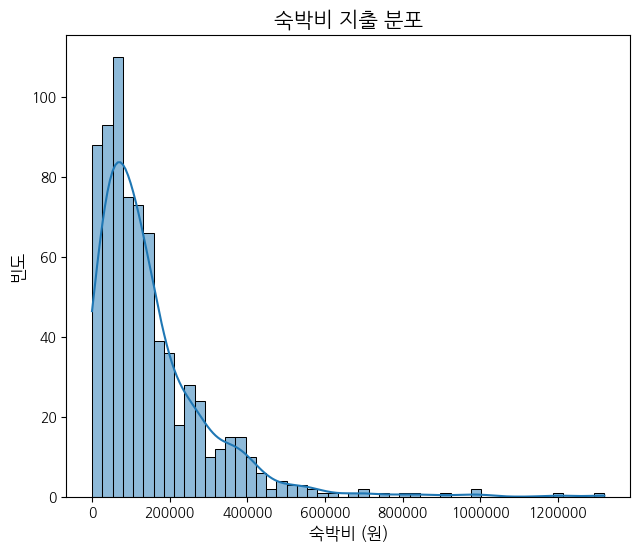

In [201]:
# --- 시각화 코드 ---
plt.figure(figsize=(16, 6))

# 1-1. 히스토그램으로 분포 확인
plt.subplot(1, 2, 1)
sns.histplot(df_lodge_clean['PAYMENT_AMT_WON'], bins=50, kde=True)
plt.ticklabel_format(style='plain', axis='x')

plt.title('숙박비 지출 분포', fontsize=15)
plt.xlabel('숙박비 (원)', fontsize=12)
plt.ylabel('빈도', fontsize=12)

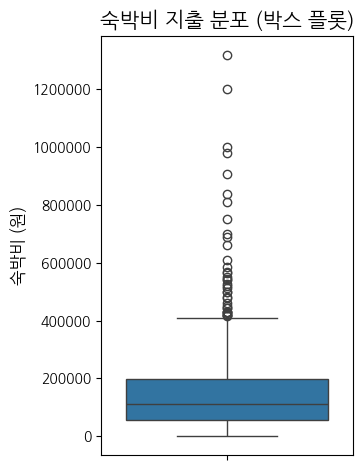

In [202]:
# 1-2. 박스 플롯으로 이상치 및 사분위수 확인
plt.subplot(1, 2, 2)
sns.boxplot(y=df_lodge_clean['PAYMENT_AMT_WON']) # x= -> y= 로 변경
plt.title('숙박비 지출 분포 (박스 플롯)', fontsize=15)
plt.ylabel('숙박비 (원)', fontsize=12)
plt.xlabel('') # 가로축 라벨은 불필요하므로 제거

# y축 숫자 형식을 일반 숫자로 변경
plt.ticklabel_format(style='plain', axis='y')

plt.tight_layout() # 두 그래프의 간격을 자동으로 조절
plt.show()

In [203]:
lodge_type_map = {
    1: '호텔',
    2: '펜션',
    3: '콘도미니엄',
    4: '모텔/여관',
    5: '유스호스텔',
    6: '캠핑',
    7: '전통숙소',
    8: '민박',
    9: '기타',
    10: '게스트하우스',
    11: '리조트',
    12: '농어촌/휴양마을'
}

# 'LODGING_TYPE_NM' (숙소유형명) 컬럼 추가
df_lodge_clean['LODGING_TYPE_NM'] = df_lodge_clean['LODGING_TYPE_CD'].map(lodge_type_map)

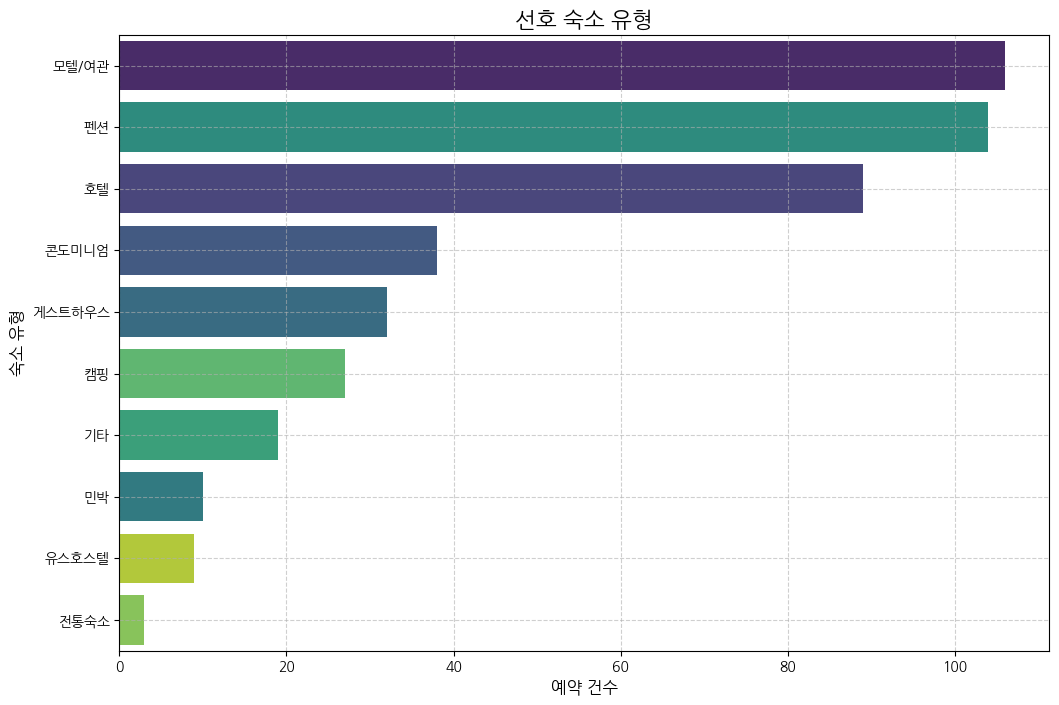

In [214]:
# --- 1. 선호 숙소 유형 (countplot 수정) ---
plt.figure(figsize=(12, 8))

# y축에 새로 만든 'LODGING_TYPE_NM' 컬럼을 사용합니다.
order = df_lodge_clean['LODGING_TYPE_NM'].value_counts().index
sns.countplot(data=df_lodge_clean, y='LODGING_TYPE_NM', order=order, 
              hue='LODGING_TYPE_NM', palette='viridis', legend=False)

plt.title('선호 숙소 유형', fontsize=16)
plt.grid(zorder=0, linestyle='--', alpha=0.6)
plt.xlabel('예약 건수', fontsize=12)
plt.ylabel('숙소 유형', fontsize=12) # 라벨도 '코드'에서 '유형'으로 변경
plt.show()